In [58]:
import numpy as np
import networkx as nx
import pandas as pd

from tqdm import tqdm
from itertools import combinations
from scipy import stats
from scipy.spatial import distance
from sklearn import decomposition, preprocessing, manifold
from collections import defaultdict
from annoy import AnnoyIndex
from datetime import datetime as dt

from news_vec.utils import read_json_gz_lines
from news_vec.encoder import read_preds

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [6]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-acc-ts-ab.json/'))))

955500it [00:02, 389894.67it/s]


In [101]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [102]:
pairs = set(map(tuple, df[['d1', 'd2']].values.tolist()))

In [103]:
rows = []
for d1, d2 in tqdm(pairs):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    lr = stats.linregress(pdf.window, pdf.acc)
    rows.append((d1, d2, lr.slope, lr.intercept, lr.pvalue, lr.rvalue))

100%|██████████| 105/105 [00:18<00:00,  5.36it/s]


In [104]:
lr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'intercept', 'p', 'r'))

In [105]:
tick_labels = [
    dt.fromtimestamp(ts).strftime('%-m/%Y')
    for ts in np.linspace(1483228802, 1537207799, 10, dtype='int')
]

In [106]:
tick_locs = np.linspace(0, len(df.window.unique()), len(tick_labels), dtype='int')

In [107]:
def plot_pairs(lr_df, path, w=8, h=30):

    fig, axes = plt.subplots(len(lr_df), 1, figsize=(w,h), dpi=100)

    for i, r in enumerate(lr_df.itertuples()):

        ax = axes[i]
        pdf = df[(df.d1==r.d1)&(df.d2==r.d2)].sort_values('window')

        fitx = np.array([pdf.window.min(), pdf.window.max()])
        fity = r.slope * fitx + r.intercept

        sns.boxplot(x='window', y='acc', data=pdf, ax=ax)
        ax.plot(fitx, fity, c='black', linewidth=3, alpha=0.7)
        ax.set_xticks(tick_locs)
        ax.set_xticklabels(tick_labels)

        title = f'{r.d1} / {r.d2}'
        ax.set_title(title, fontdict=dict(fontsize=16, fontweight='bold'))
        ax.set_xlabel(None)
        ax.set_ylabel('Accuracy')

    plt.tight_layout(h_pad=2)
    plt.savefig(path)
    plt.show()

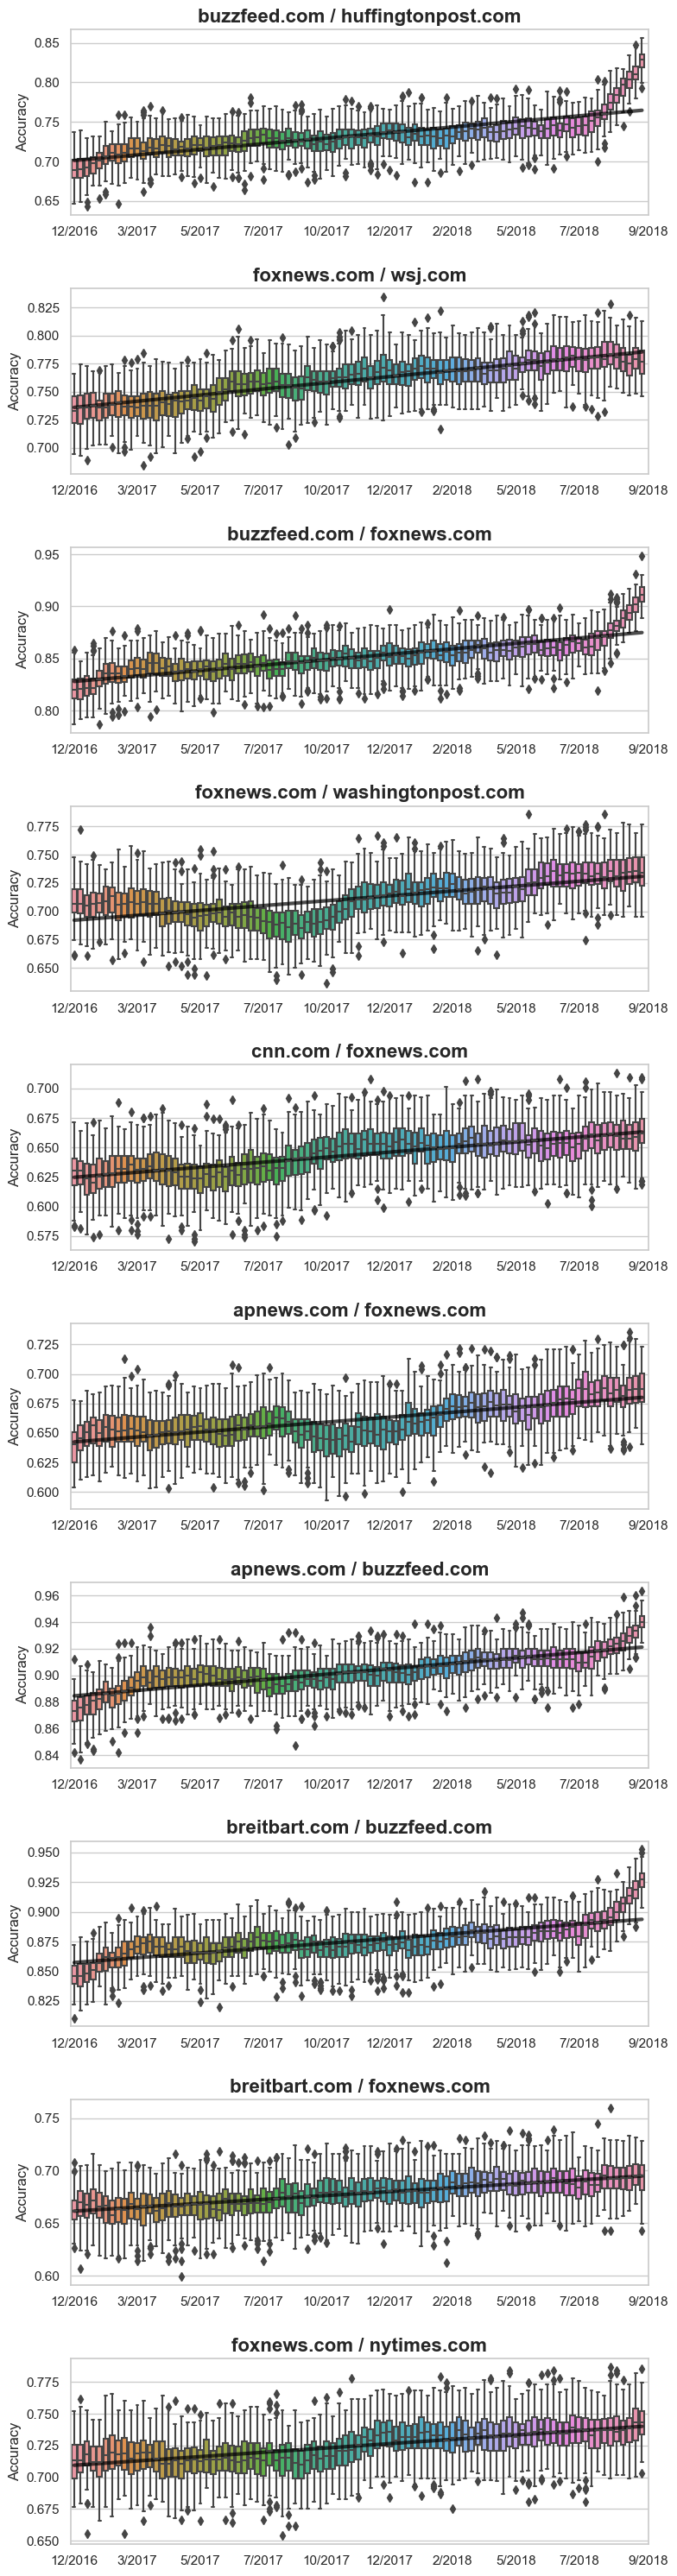

In [108]:
plot_pairs(lr_df.sort_values('slope', ascending=False).head(10), 'figures/ts-ab-rising.png')

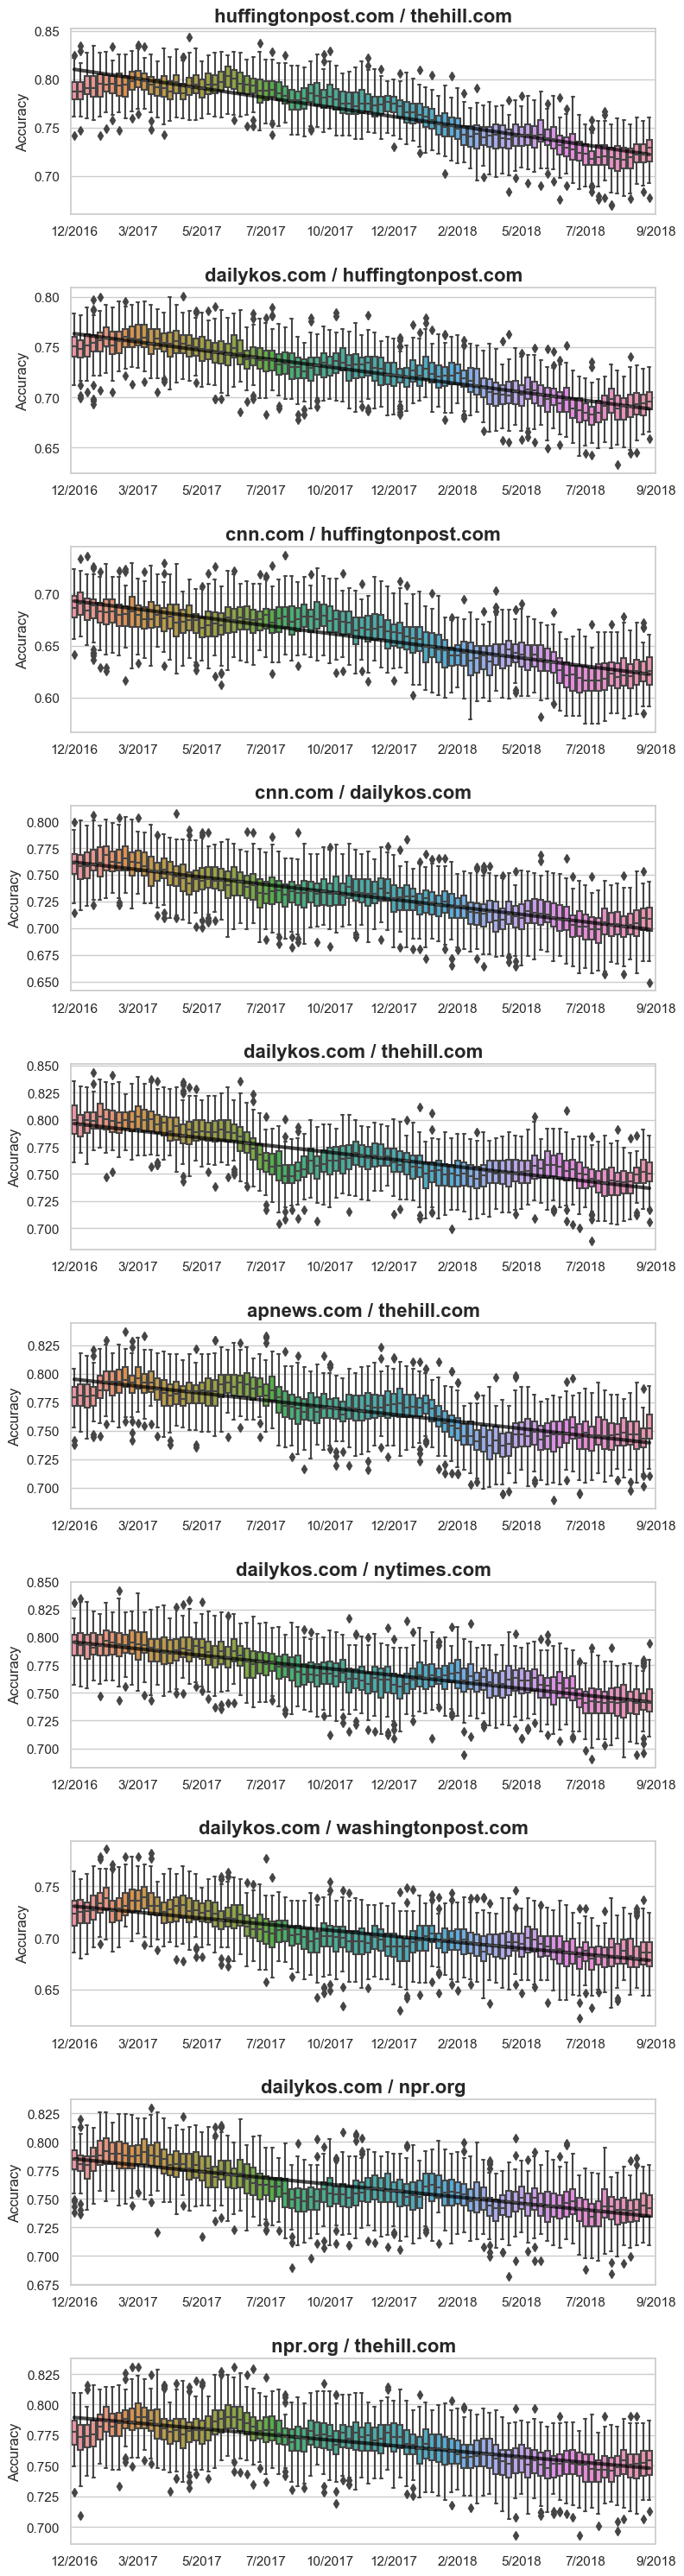

In [109]:
plot_pairs(lr_df.sort_values('slope', ascending=True).head(10), 'figures/ts-ab-falling.png')

In [110]:
lr_df['label'] = lr_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

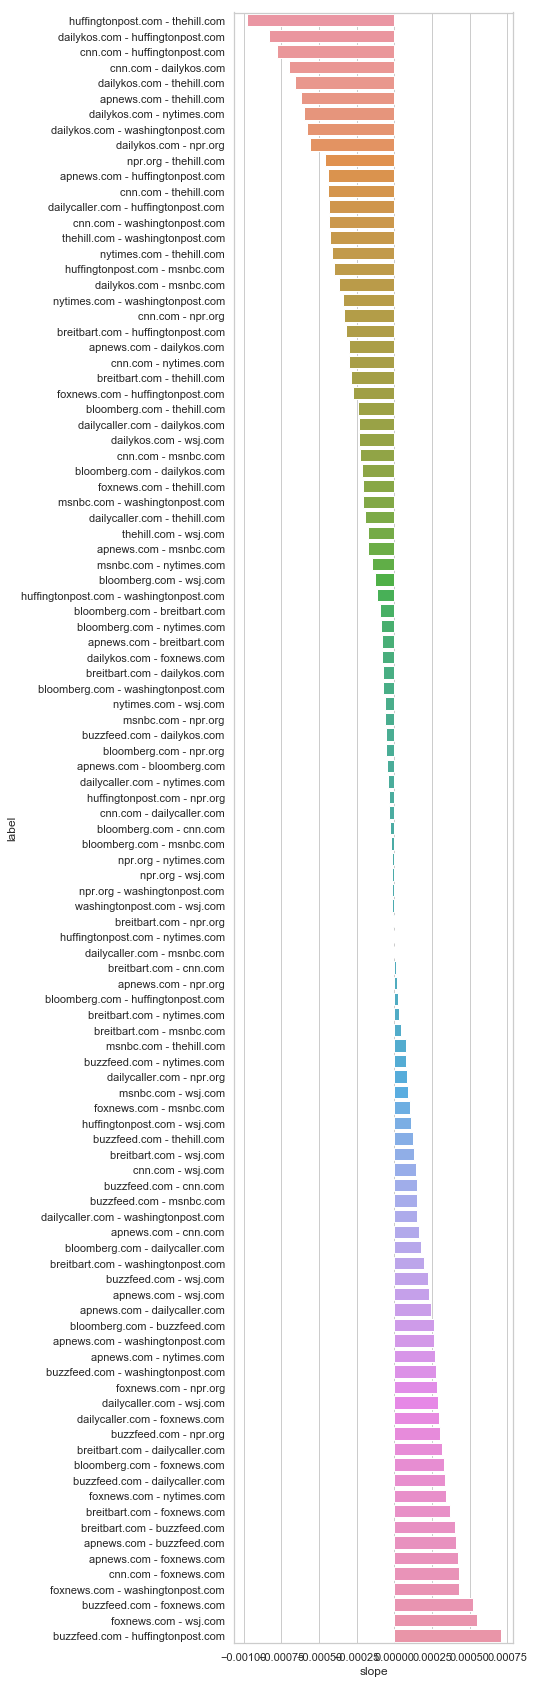

In [111]:
plt.figure(figsize=(5,30))
sns.barplot(x='slope', y='label', data=lr_df.sort_values('slope'))

In [112]:
lr_df['color'] = lr_df.slope.apply(lambda s: 'red' if s > 0 else 'blue')
lr_df['width'] = preprocessing.minmax_scale(abs(lr_df.slope), (0,3)) ** 2

In [113]:
g = nx.Graph()
for r in lr_df.sort_values('slope').itertuples():
    g.add_edge(r.d1, r.d2, width=r.width, color=r.color)

In [114]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


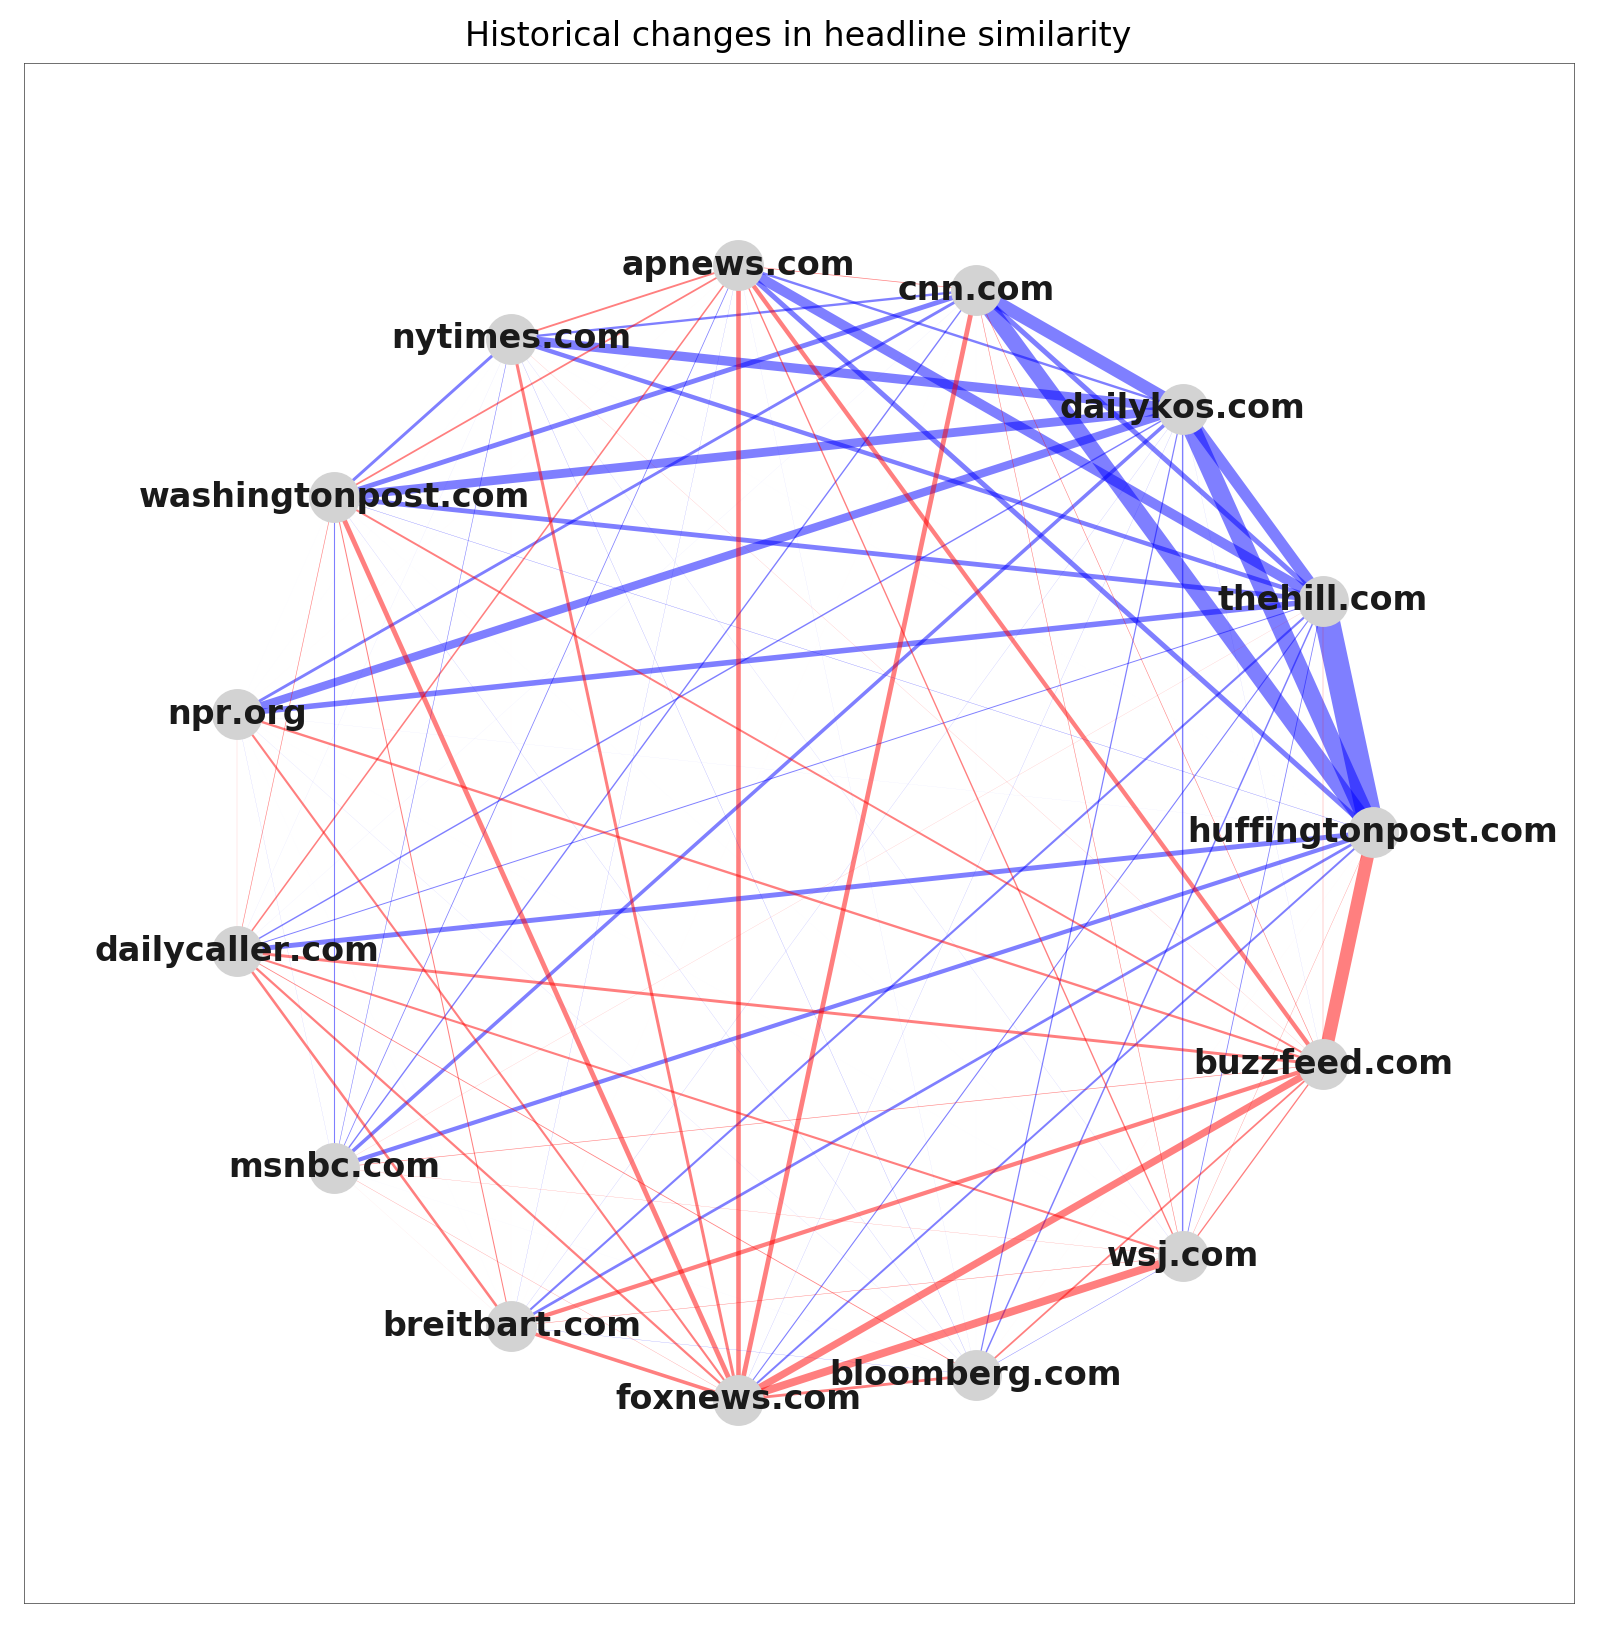

In [115]:
mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity')

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray')
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')

plt.savefig('figures/ts-ab-radial.png', bbox_inches='tight')

In [116]:
lr_df.to_json('data/ts-ab-lr.json', orient='records', lines=True)

In [122]:
pred_df, embeds = read_preds('../../data/ava-cnn/')

100%|██████████| 284/284 [00:16<00:00, 17.45it/s]


In [123]:
pred_df['tokens_key'] = pred_df.clf_tokens.apply(lambda ts: tuple(ts))

In [124]:
pred_df = pred_df.drop_duplicates('tokens_key', keep=False)

In [125]:
pred_df_start = pred_df[pred_df.windows.apply(lambda ws: any(np.array(ws) < 10))]
pred_df_end = pred_df[pred_df.windows.apply(lambda ws: any(np.array(ws) > 80))]

In [126]:
idx_start = AnnoyIndex(embeds.shape[1])
for i in tqdm(pred_df_start.index):
    idx_start.add_item(i, embeds[i])
    
idx_end = AnnoyIndex(embeds.shape[1])
for i in tqdm(pred_df_end.index):
    idx_end.add_item(i, embeds[i])

100%|██████████| 49565/49565 [00:03<00:00, 12542.88it/s]


In [127]:
idx_start.build(20)
idx_end.build(20)

True

In [128]:
def mean_cosine_d(domain):
    
    df1 = pred_df_end[pred_df_end.domain==domain]
    df2 = pred_df_start[pred_df_start.domain==domain]
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)
    
    return distance.cosine(v1, v2)

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


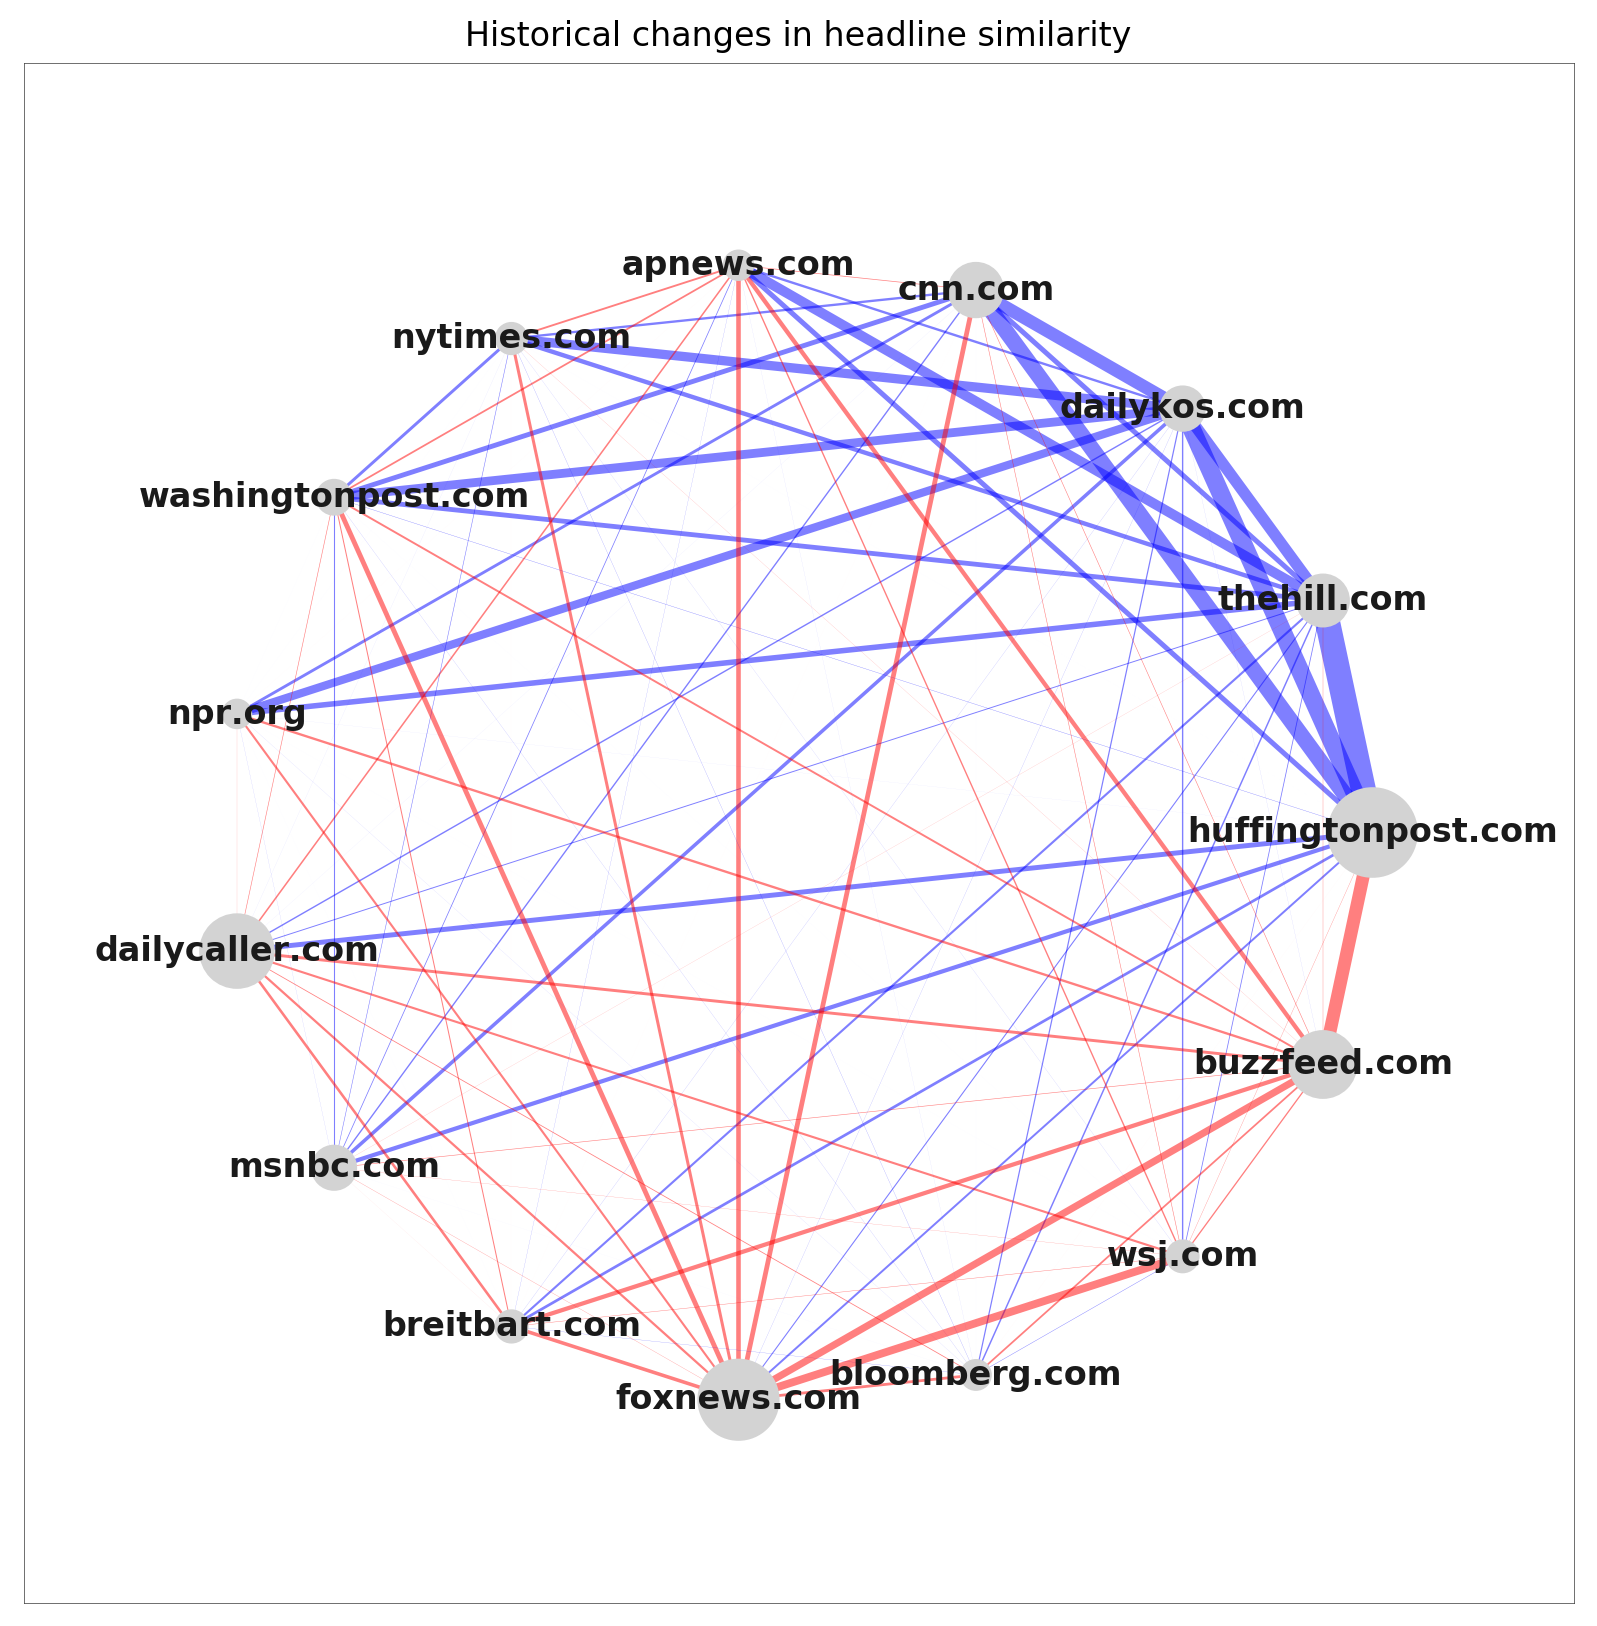

In [129]:
edge_width = [d['width'] for _, _, d in g.edges(data=True)]
edge_color = [d['color'] for _, _, d in g.edges(data=True)]
node_size = preprocessing.minmax_scale([mean_cosine_d(n) for n in g.nodes], (100,1000))

mpl.style.use('default')
plt.figure(figsize=(10,10), dpi=200)
mpl.rc('axes', linewidth=0.2)
plt.xlim(-1.35,1.35)
plt.ylim(-1.35,1.35)
plt.xticks([])
plt.yticks([])
plt.title('Historical changes in headline similarity')

pos = nx.layout.circular_layout(g)
nx.draw_networkx_nodes(g, pos, node_color='lightgray', node_size=node_size)
nx.draw_networkx_edges(g, pos, edge_color=edge_color, width=edge_width, alpha=0.5)
_ = nx.draw_networkx_labels(g, pos, font_weight='bold')

In [130]:
def delta_hls(df1, df2, idx, domain=None, n=20, probe=10000):
    
    v1 = embeds[df1.index].mean(0)
    v2 = embeds[df2.index].mean(0)

    matches = 0
    for i in idx.get_nns_by_vector(v2-v1, probe):
        
        r = pred_df.loc[i]
        
        if not domain or r.domain == domain:
            print(' '.join(r.clf_tokens))
            matches += 1
            if matches == n:
                break
                
    print(distance.cosine(v1, v2))

In [131]:
def delta_hls_domain_start(domain):
    
    delta_hls(
        pred_df_end[pred_df_end.domain==domain],
        pred_df_start[pred_df_start.domain==domain],
        idx_start,
        domain,
    )

In [132]:
def delta_hls_domain_end(domain):
    
    delta_hls(
        pred_df_start[pred_df_start.domain==domain],
        pred_df_end[pred_df_end.domain==domain],
        idx_end,
        domain,
    )

# Buzzfeed

In [133]:
delta_hls_domain_start('buzzfeed.com')

dakota access pipeline challengers race to court to block construction
trump vineyard seeks more foreign workers
trump begins rolling back major obama water pollution rule
trump wrote iraq wmds were threat year before bush took office
trump winery seeks even more foreign workers
alongside trump intel reannounces arizona factory
trump moves to challenge vaccine science
trump gets anonymity after dissing anonymous sources
with tough re elections looming democrats plot confirmation hearing strategy
epa s science panel might soon be stacked with polluters
tom steyer moves beyond climate
guardian ditches move to kushner building after newsroom revolt
naacp leaders romney ca nt connect with black audiences
pentagon presenting options for military action in syria
#th century fox optioned bill oreilly wwii book months before his exit
employers abuse foreign workers us says by all means hire more
trump says post crisis financial rules will be cut back
democrats confront lefty fake news
us intel

In [134]:
delta_hls_domain_end('buzzfeed.com')

build a trendy hipster meal and we ll tell you which ya heroine you are
write a love letter and we ll tell you which to all the boys character you re compatible with
eat a bunch of food and we ll tell you which spongebob character you are
rate these movie theater snacks and we ll reveal if you d survive in a slasher film
make a break up playlist and we ll tell you which marvel superhero you re most compatible with
pick some colored shirts and we ll reveal which the breakfast club character you re most like
make a breakup playlist and we ll tell you which marvel superhero you re most compatible with
pick your first day of school outfit and we ll tell you if you re a freshman sophomore junior or senior
order some mcdonald s and we ll reveal whether your soulmate is more like jamey or peter kavinsky
choose between these gucci items and we ll tell you which disney princess you are
see a movie at the premiere and we ll tell you if you re more drake or josh
plan a movie night and we ll tell 

# HuffPo

In [135]:
delta_hls_domain_start('huffingtonpost.com')

a memorable book about forgetting
the best tomato recipes ever
a few of my favorite tech products
the pyramids you never knew existed
when it s your time to dance dance
the things they do nt tell you about grief
how yoga nidra works
lennon and maisy s cover of coldplay s up and up will make you smile
where is the love building belonging in an age of divisiveness
how to buy the best wine at the grocery store
once upon a time two teens took the music patriarchy to task
how many people are vegetarian
at a glance guide to the temples of angkor wat
the dating game of hot and cold
what s so funny
what s the line between authenticity and tmi
how to be sure you re buying a real bottle of chianti
are women tech savvy
cesar chavez s words of wisdom are all the inspiration you ll need today
one minute of just us a classical music social experiment
0.0330125093460083


In [136]:
delta_hls_domain_end('huffingtonpost.com')

ny daily news shreds clown king trump in blistering independence day cover
msnbc silent on joy reid as blog scandal resurfaces
ny times reporter confirms obama made deal to kill public option
kathy griffin goes topless to celebrate manafort cohen guilty verdicts
emails show michigan republicans scheming to gerrymander garbage dems
trump promotes video of supporters chanting cnn sucks at florida rally
kavanaugh accuser willing to testify before senate judiciary committee laywer
moron harangues woman in park for wearing puerto rico shirt in america
florida dem candidate for governor relying on vocal trump supporter
michelle obama recruits celebrity team for voter registration campaign
stormy daniels misdemeanor charges dropped after ohio strip club arrest
alexandria ocasio cortez terrifies daily caller editor who nearly falls for her populism
msnbc host hugh hewitt suggests trench coat control not gun control
maxine waters says number of death threats increased after trump called her out

# Fox

In [137]:
delta_hls_domain_start('foxnews.com')

no plans to fill unnecessary appointed positions
teachers unions in a panic over school choice
best job search websites
bikepacking adds a dose of fun to backpacking
fewer fret over more focus on politics
eurozone growth edging higher at the start of second quarter
is health care a right
five reasons not to observe lent
governor of puerto rico on debt crisis push to become state
a rare look inside an insulated yet menacing country
mosquitoes and ticks are coming for us all this summer
is whiskey becoming less popular
ceo gives job applicants a snowflake test
reformist head of ukraine s central bank resigns
is zika still a concern
one way or another confirm judge gorsuch
trump starts over with tax plan
who runs the world
stock it or skip it how to cut grocery costs
agriculture nominee will distance himself from businesses
0.026443898677825928


In [138]:
delta_hls_domain_end('foxnews.com')

florida female felon s bloody mugshot the result of her head on crash while fleeing cops officials say
sc woman allegedly told cops she s a clean thoroughbred white girl after being pulled over
jefferson airplane singer marty balin sues hospital claiming he lost part of his tongue after botched tracheotomy
smallville actress allison mack asks court to let her continue acting amid nxivm sex cult allegations
charlie sheen claims he ca nt afford child support after being blacklisted in hollywood says report
gunman shot by florida armed bystander still hospitalized nra says shooting example of good guy with a gun
the wire creator david simon reveals in profanity laced post that he was banned from twitter after wishing death on trump supporter
world renowned lesbian nyu professor suspended after probe finds she sexually harassed gay male student report says
carter page was more like inspector gadget than jason bourne gowdy says amid fisa release
ohio grocery store employee facing felony the

# DailyKos

In [139]:
delta_hls_domain_start('dailykos.com')

trumpcare is even less popular than donald trump
trumpcare is the ultimate distraction but do nt forget donald trump is already drowning in scandals
four republican governors tell ryan mcconnell to nix house trumpcare bill as is
tom perez slams donald trump republicans and trumpcare they do nt give a shit about people
looks like paul ryan is capitalizing on trump s ignorance to rush obamacare repeal
one way or the other donald trump is a liar here is documented proof
the photo of a regretful trump supporter is going viral on donald s own playground twitter
republicans plan a quick start on their pro corporate pro polluter anti healthcare agenda
these # congressional districts flipped to donald trump after backing barack obama in #
donald trump lied about executive orders because donald trump lies about everything
four republican senators tell mcconnell to save medicaid expansion
donald trump learned a very important message today do not pick a fight with elizabeth warren
republicans ho

In [140]:
delta_hls_domain_end('dailykos.com')

us forces sodomized prisoners at bagram with sticks
michigan health director to stand trial for manslaughter in flint water related deaths
old man shakes fist at cloud yells fair trade
prosecutor says she dropped charges against greitens in exchange for resignation
rhino poachers eaten by lions on game reserve in south africa
loss of gene puts marine mammals at risk from organophosphate pesticides
freed from death row sabrina butler smith s story
california court cracks down on widespread wage theft
selling fossils lizard origins probiotic flies
ozone eating chemical makers revealed arms race in space
primary night pot beer and dead fish
blue dog ed case mounts unexpected comeback in hawaii
wyoming to decide whether to allow yellowstone region trophy hunting of grizzlies
day sixteen kremlinannex #pm et
roll up roll up for the mystery tour
north korea snubs united states on talks over returning war dead
florida man charged with manslaughter despite claiming stand your ground
day twenty 

# The Hill

In [141]:
delta_hls_domain_start('thehill.com')

spending deal coming very soon
trump hotels eyes us expansion
pence meets with bono
putin trump in spotlight
trump all talk on wall street
trump gets tough with canada
net neutrality fix faces hard sell
white house tax plan coming very soon
trump s labor nominee to withdraw
nato mission will go forward
trump s russia problem deepens
trump s marijuana options
trump not always fun to play
us manufacturing expanded in march
trump set to meet with ceos on friday
fox executives fear more to come
trump should release tax returns
burr us in new cold war with russia
pence on russia we re watching
senators delay vote on trump budget pick
0.00934135913848877


In [142]:
delta_hls_domain_end('thehill.com')

buck wild brett kavanaugh has created the deepest puddle of liberal tears since trump s # victory
ariz woman says pharmacist refused to fill miscarriage prescription due to his ethical beliefs
apartment repairman says building resident went on racist rant threw hot coffee in his face
former vatican ambassador claims popes francis benedict knew of allegations against former archbishop of washington
video of swedish woman stopping afghan man s deportation by refusing to sit down on plane goes viral
doctors scientists say microwave strikes may have caused mysterious ailments of us embassy workers
ex sheriff david clarke describes how he would have stopped anti fascists in #s germany on who is america
anti racist protesters in charlottesville angered by heightened police presence riot gear
rogue house republicans are preparing to grant amnesty to # million illegal aliens
doj official was unethical in investigating trump campaign because his wife worked for fusion gps
black man who had cops

# DailyKos

In [145]:
delta_hls_domain_start('dailycaller.com')

house clears health care rules vote
smok marshal g# tc vape kit
investors lock in on fatty liver drug as next big payout
wismec reuleax rx#s review
a positive jobs report could mean interest rate hike
zero cuts to entitlements in new budget
irs wo nt reject tax returns that skip health coverage question
nobody likes obamalunch either
eight tips for secure online privacy
choice act iv a new hope
humans need closer merger with machines to avoid getting terminated
gas prices are rising to highest point in last # years
daywithoutimmigrants leads to immigrantswithoutjobs
first us clean coal power plant is operational
cut to the russian chase
name mix up causes stocks to surge for lucky company
hcigar vt# dna# box mod review
pence clarifies us stance on nato russia
twitter gets its worst critique yet from one of its earliest investors
trump lands himself some unusual allies with tpp move
0.021762192249298096


In [146]:
delta_hls_domain_end('dailycaller.com')

black conservative activist stands with judge jeanine in viral video no group in america more bigoted than leftists
here are horrifying photos of obama s illegal alien facilities the media refuses to show you
former director of national intelligence james clapper agrees with cnn anchor that rodman knows trump and kim jong un both better than anybody
language is not a race tucker explodes when guest paints trump as wildly racist for complimenting ice agent s english
tucker carlson points out the blatant hypocrisy of the media antifa vs unite the right
twitter silent on actor s insane tweet about putting barron trump in a cage with pedophiles harassing ice agents children
melania trump s spokeswoman responds perfectly to cnn reporter asking if flotus was watching cnn on air force one
antifa punch man during facebook live at unite the right rally and chant anti american slogans
tucker says dems support open borders for reliable new voters slams republicans perfectly happy to grand their w